# DS4D: Assignment 2
Sarah Schöttler

**NOTE: There were some inconsistencies in the Excel sheet which were much faster to fix by editing the file directly, and which also make the code that follows a little easier to read. This notebook will therefore not run on a 'fresh' copy of the file. The changes I made in Excel are the following: Removed an extra line at the top of the Age sheet, consistently named the Question column 'Question', deleted the extra column 'Reported better experience' in the Gender sheet, edited column names in the Deprivation sheet to not consist of a single number only.**

## Part I: Describe

### Brief

Describe: tell us about the data that you have. We expect to see:
- what is the general type of the data (tabular, network, geographical, textual etc.)
- how large and complex is it (rows/columns, size, variation, structure)
- What fields and data types are present (max/min, levels for categorical values).
- Links between this data and other data (e.g. foreign keys, unique ids)
- Summary statistics about the data - how many people, what time frame, field averages etc.
- How does the data relate to the questions that the data owner has discussed with you?


### About the data

Since 2011, the Scottish Government has ran the [Scottish Patient Experience Survey of GP and Local NHS Services](https://www2.gov.scot/Topics/Statistics/Browse/Health/GPPatientExperienceSurvey) every other year. There are a number of publications containing different kinds of analyses that have been released to the public. The data we are working with stems from one of these: a variations analysis of the survey results from 2011/2012. We were provided with odds ratios, which describe the relationship between a patient's experience and different characteristics of the patient, such as their demographic data. 18 different characteristics were considered, amongst them for example age, religion, whether people live in urban or rural regions, and what their health status is. 

The data was provided to us as an Excel file with 18 separate sheets, one for each characteristic. Each sheet contains less than 100 rows, so it is not really a large dataset - this is of course because it is the result of a statistical analysis. As such, it is a summary of the original dataset already. The original dataset (over 140,000 survey responses) is not publicly available. Other publications related to the same dataset are available, and it might be worth considering using some of this for our third assignment. The datasets are not formally linked through IDs or foreign keys, but the survey questions and themes should be the same.

The sheets are formatted roughly the same, although there are some inconsistencies (see note at the top, as well as additional difficulties such as cells being merged on some sheets, but not on others). For this assignment, my group has decided to split it into the different Excel sheets - I am working on the middle six. However, I nonetheless made sure my code to read the data in works for all 18 sheets, to make it reusable for the last assignment. For the rest of this assignment, I focus on my sheets.

### About our project

The data owners have asked us to look into better ways of visualising the data. Their main goal is to provide better ways for policy makers to get useful insights out of this data, and to use it to develop policies in the healthcare sector. They have already done thorough analyses of the data and published in-depth reports describing interesting findings, however, as they say themselves, these reports are rather dry and unlikely to be referred back to throughout the process of developing new policy. Our goal is therefore not so much to find new insights, but more to create engaging visualisations which depict the data accurately and let viewers discover many of the insights already described in the reports with ease. 

### Reading in and cleaning the data

On each sheet, the actual data table only starts in row 3. However, the top left cell contains information on the base group, without which the data is impossible to interpret correctly. This therefore has to be preserved in addition to the tables.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Assign spreadsheet filename to `file`
file = 'data_sarah.xls'

# Load spreadsheet
xl = pd.ExcelFile(file)

# There are 18 sheets in total, I am selecting the six sheets I am working on
mysheets = xl.sheet_names[6:12]

description = [] # for the description of each sheet
df_raw = [] # for the df's returned by parsing the excel sheet

# Read in all descriptions and sheets
for i, sheet in enumerate(mysheets):

    # The top left cell of each sheet contains a description that puts the 
    # data in the sheet into context
    description.append(xl.parse(sheet, header=None, nrows=1)[0][0])

    # The actual data table starts in row 3
    df_raw.append(xl.parse(sheet, header = 2))
    
# Print one as an example
df_raw[5]

,Theme,Question,Yes,COL1
0,Care and treatment,Are you involved as much as you want to be in ...,0.804,-
1,Care and treatment,NaN,"(0.711 ,0.910)",-
2,Medicines,I knew enough about what my medicines were for,0.646,-
3,Medicines,NaN,"(0.540 ,0.772)",-
4,Medicines,I knew enough about how and when to take my me...,0.549,-
5,Medicines,NaN,"(0.441 ,0.683)",-
6,Medicines,I knew enough about possible side effects of m...,0.780,-
7,Medicines,NaN,"(0.701 ,0.868)",-
8,Medicines,I would know what to do if I had any problems ...,0.717,-
9,Medicines,NaN,"(0.632 ,0.813)",-


Here, we can see that there are several issues with the format this data is stored in currently:
- For each question and each category in a certain characteristic, the odds ratio as well as the upper and lower bound of the 95% confidence interval are given. However, these are currently formatted with the question cell containing of two merged cells, and the odds ratio and the confidence interval in two cells above each other. These need to be split into a clear row/column structure without merged cells or cells containing multiple values.
- The question text is missing in every other row (this is because these rows were merged in Excel). However, we know for each of these rows that the correct question is in the row above.
- There are additional columns which siply indicate whether the confidence interval includes 1 or not (these were used to shade the cells in Excel), these can be removed.




In [3]:
df = [] # clean dataframes will go in here later

# iterate through all parsed sheets and clean/reformat them
for dfr in df_raw:
    
    # Remove COLx (they only describe information that is already contained 
    # in the other columns)
    cols = dfr.columns
    pattern = r'^COL*'
    cols_to_keep = cols[~cols.str.match(pattern)]
    dfr = dfr[cols_to_keep]
    
    # Because of how the Excel sheet was formatted, we need to split out the
    # odd rows
    
    # Create index lists for odd and even rows
    even = np.array(range(0, len(dfr), 2))
    odd = np.array(range(1, len(dfr), 2))
    
    # Separate dataframes - we will add the odd rows back into the df with the
    # even rows later
    df_clean = dfr.iloc[even, :].reset_index(drop=True) # even rows
    df_odd = dfr.iloc[odd, 2:].reset_index(drop=True) # odd rows
    
    # Melt dataframe into long shape
    df_clean = df_clean.melt(id_vars=['Theme', 'Question'], 
                 var_name='group', 
                 value_name='odds_ratio')
    
    # Theme and question are mostly missing because of the merged cells in the
    # Excel sheet, but they are ordered correctly, so I can just replace those
    # columns with the ones from the dataframe with the even rows
    df_odd['Theme'] = df_clean['Theme']
    df_odd['Question'] = df_clean['Question']
    
    # Melt the dataframe with the odd rows as well
    df_odd = df_odd.melt(id_vars=['Theme', 'Question'], 
                 var_name='group', 
                 value_name='conf')
    
    # Split the column with the confidence interval into separate columns
    conf_split = df_odd['conf'].str.replace(r'\(|\)', '').str.split(',', expand=True)
    # Add into the clean dataframe
    df_clean['conf_lower'] = conf_split[0]
    df_clean['conf_upper'] = conf_split[1]
    
    # lowercase column names
    df_clean.columns = df_clean.columns.str.lower()
        
    # convert columns with numbers to numeric type
    for colname in df_clean.columns[3:]:
        df_clean[colname] = pd.to_numeric(df_clean[colname])

    # Append clean dataframe to list
    df.append(df_clean)

At this point, I have turned each Excel sheet into a clean dataframe. However, the context from the description, i.e. according to which characteristic respondents have been categorised, and what the base group for the odds ratio is, are not in the dataframe. I have therefore decided to add these manually so that I can merge all dataframes together without losing this context.

In [4]:
# Add additional information from the descriptions, then merge
# This would need to be expanded to make this code work for all 18 sheets
info = [["Urban-Rural", "Large urban areas"],
        ["Work Status", "Retired"],
        ["Carers", "Not a carer"],
        ["Health status", "Good"],
        ["Limitation of day-to-day activities", "Not limited"],
        ["Interpretation, translation or other communication support needs", "No"]]

# Insert two additional columns for the additional information
for i in range(len(df)):
    df[i].insert(2, 'characteristic', info[i][0])
    df[i].insert(3, 'base_group', info[i][1])

# Concatenate all dataframes, yielding one big dataframe df which contains all our data
df = pd.concat(df)

# Reset index to number rows sequentially
df = df.reset_index(drop=True)

### A first look at the cleaned data

Printing the first dataframe and its description as an example, we can see that the data is now neatly organised. There are three numerical columns, containing the odds ratio and the lower and upper bounds of the confidence interval. The remaining columns are text data, containing the theme, question, characteristic, base group and group for the odds ratio recorded in each row. This structure is entirely different from the original Excel sheet and was chosen because it conforms to the principles of clean data, which simplifies all further analysis a lot.

However, it should be noted that even though I chose to compile all the data into a single dataframe, one has to be extremely careful in comparing odds ratios across different base groups. To give an example, an odds ratio of 0.7 for those working full-time compared to an odds ratio of 0.9 for males does not indicate that full-time workers are worse off than males - it only indicates that one is worse of than the other *compared to their respective base groups.*

In [5]:
df

,theme,question,characteristic,base_group,group,odds_ratio,conf_lower,conf_upper
0,Access,Thinking of the last time you contacted this G...,Urban-Rural,Large urban areas,Other Urban Areas,0.907,0.789,1.043
1,Access,"The last time you phoned the GP surgery, how h...",Urban-Rural,Large urban areas,Other Urban Areas,0.940,0.803,1.100
2,Access,The last time you needed to see or speak to a ...,Urban-Rural,Large urban areas,Other Urban Areas,0.902,0.796,1.022
3,Access,If you ask to make an appointment with a docto...,Urban-Rural,Large urban areas,Other Urban Areas,0.934,0.813,1.074
4,Access,When you arrange to see a doctor at your GP su...,Urban-Rural,Large urban areas,Other Urban Areas,0.950,0.839,1.076
5,Access,Overall how would you rate the arrangements fo...,Urban-Rural,Large urban areas,Other Urban Areas,0.941,0.841,1.052
6,Access,Overall how would you rate the arrangements fo...,Urban-Rural,Large urban areas,Other Urban Areas,0.903,0.798,1.021
7,Referrals,Thinking about the last time your GP referred ...,Urban-Rural,Large urban areas,Other Urban Areas,0.966,0.884,1.056
8,At your GP surgery,How helpful do you find the receptionists at y...,Urban-Rural,Large urban areas,Other Urban Areas,1.013,0.869,1.181
9,At your GP surgery,How clean is your GP surgery or health centre?,Urban-Rural,Large urban areas,Other Urban Areas,1.106,0.991,1.234


### Summary Statistics

Firstly, some basic data on the size of the data and the different datatypes. This is of course not really surprising because all of the code above has the purpose of making it look exactly this way.

In [6]:
print("Columns:", df.shape[1], "\nRows:   ", df.shape[0])
print("Data types:\n", df.dtypes, sep='')

Columns: 8 
Rows:    593
Data types:
theme              object
question           object
characteristic     object
base_group         object
group              object
odds_ratio        float64
conf_lower        float64
conf_upper        float64
dtype: object


The survey was split into different themes. Not all themes are present for all characteristics, but overall there are 9 unique themes:

In [7]:
for theme in df.theme.unique():
    print(theme)

Access
Referrals
At your GP surgery
Doctor
Nurse
Medicines
Overall care
Out of Hours
Care and treatment


Each theme was investigated using one or more survey questions. The following is a list of all unique questions, sorted by the theme they belong to.

In [8]:
print("Total number of unique questions:", len(df.question.unique()))
for theme in df.theme.unique():
    print('\n---', theme, '---')
    for q in df[df.theme==theme].question.unique():
        print(q)

Total number of unique questions: 39

--- Access ---
Thinking of the last time you contacted this GP surgery by phone, how easy was it for you to get through?
The last time you phoned the GP surgery, how helpful was the person who answered?
The last time you needed to see or speak to a doctor or nurse from your GP surgery quite urgently, how long did you wait?
If you ask to make an appointment with a doctor 3 or more working days in advance, does your GP practice allow you to?
When you arrange to see a doctor at your GP surgery can you usually see the doctor you prefer?
Overall how would you rate the arrangements for getting to see a doctor in your GP surgery?
Overall how would you rate the arrangements for getting to see a nurse in your GP surgery?

--- Referrals ---
Thinking about the last time your GP referred you, how would you rate the arrangements for getting to see another NHS health professional?

--- At your GP surgery ---
How helpful do you find the receptionists at your GP s

Next, let's list the six characteristics I am looking at - the survey responses were split into groups depending on different characteristics of the respondents, so that it could be evaluated how much of an effect belonging to a certain group has on someone's healthcare experience.

In [9]:
for c in df.characteristic.unique():
    print(c)

Urban-Rural
Work Status
Carers
Health status
Limitation of day-to-day activities
Interpretation, translation or other communication support needs


For each characteristic, one of the groups was chosen as the base group, and odds ratios were calculated for all other groups relative to the base group. Let's see which ones there are:

In [10]:
for c in df.characteristic.unique():
    print(c)
    print('- Base group:  ', df[df['characteristic']==c].base_group.unique()[0])
    print('- Other groups:', df[df['characteristic']==c].group.unique())

Urban-Rural
- Base group:   Large urban areas
- Other groups: ['Other Urban Areas' 'Accessible small towns' 'Remote Small Towns'
 'Accessible rural' 'Remote Rural']
Work Status
- Base group:   Retired
- Other groups: ['Work full time' 'Work part time' 'In full-time education or training'
 'Unemployed / Looking for work'
 'Do not work due to illness or disability' 'Other']
Carers
- Base group:   Not a carer
- Other groups: ['Yes, up to 19 hours a week' 'Yes, 20-34 \nhours a week'
 'Yes, 35 or more hours a week']
Health status
- Base group:   Good
- Other groups: ['Fair' 'Bad']
Limitation of day-to-day activities
- Base group:   Not limited
- Other groups: ['Yes, limited \na lot' 'Yes, limited \na little']
Interpretation, translation or other communication support needs
- Base group:   No
- Other groups: ['Yes']


Lastly, let's look at some summary statistics of the numerical data. As already stated above, one has to be careful not to compare odds ratios across different base groups. I am going to print some min/max values to get a better impression of the range of numbers in this dataset, and how much variation there is between groups overall. The minimum upper bound and maximum lower bound of the confidence interval show that there are certain groups that are very clearly at an advantage or disadvantage compared to the base group. However, which group or question any of these numbers belongs to is irrelevant, because the actual numbers are entirely dependent on the (arbitrarily chosen) base group.

In [11]:
print("Min. odds ratio:", min(df.odds_ratio))
print("Max. odds ratio:", max(df.odds_ratio))
print("Min. lower bound of confidence interval:", min(df.conf_lower))
print("Max. lower bound of confidence interval:", max(df.conf_lower))
print("Min. upper bound of confidence interval:", min(df.conf_upper))
print("Max. upper bound of confidence interval:", max(df.conf_upper))
print("Largest confidence interval: ", max(df.conf_upper - df.conf_lower))
print("Smallest confidence interval:", min(df.conf_upper - df.conf_lower))

Min. odds ratio: 0.397
Max. odds ratio: 1.57
Min. lower bound of confidence interval: 0.342
Max. lower bound of confidence interval: 1.314
Min. upper bound of confidence interval: 0.461
Max. upper bound of confidence interval: 1.875
Largest confidence interval:  0.6830000000000002
Smallest confidence interval: 0.049000000000000044


## Part II: Explore

Considering that our dataset is already the result of an in-depth statistical analysis, there are not too many possibilities to find correlations in this dataset. Many ways of plotting datapoints versus each other could actually be extremely misleading, because, as stated before, odds ratios cannot simply be compared. I will therefore, in addition to doing a basic exploration, focus on exploring different ways of visualising the data, and what their advantages and disadvantages are. This also relates to the second part of our project, which focuses entirely on the visualisation of this dataset.



Explore: carry out a deeper exploration of the data. This includes looking at individual fields/variables to see the distribution of values they take (e.g. evenly distributed, bell curves, bi-modal) or how they are distributed in time. It also includes relationships between variables in your dataset: are there correlations? In which direction? Complex curves? We would expect to see roughly:
- 4-5 exploratory visualisations, presented in a readable form, with an explanation about what you have found
- 1-2 relationships between variables analysed
- Ideas about trends, outliers, clusters
- Reference to statistics, i.e. a sense of which relationships are significant, and what claims you can back up.



In [12]:
# Import some additional libraries for this
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

sns.set_style("white")

### Distribution plot
First, let's look at a simple distribution plot. We can see that the distribution off the odds ratios is centred approximately at 0.8, and that the majority of the confidence intervals end below 1. Considering that generally, the largest group was chosen as the baseline (drawn in grey), we can interpret this to mean that overall, minorities such as carers have a worse healthcare experience. However, the largest group of survey respondents does not necessarily reflect the largest group in the population, so this hypothesis would need to be checked carefully.

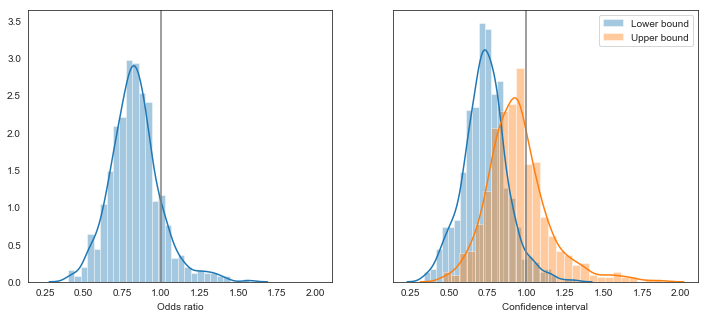

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), sharey=True, sharex=True)

sns.distplot(df.odds_ratio, ax=ax1)
ax1.axvline(1, c='grey')
ax1.set_xlabel('Odds ratio')

sns.distplot(df.conf_lower, ax=ax2, label='Lower bound')
sns.distplot(df.conf_upper, ax=ax2, label='Upper bound')
ax2.axvline(1, c='grey')
ax2.set_xlabel('Confidence interval')
ax2.legend()

plt.show()

To get an overview of the distribution of the experiences for each different characteristic, I am using some simple line plots. Lines are a better choice than dots here because while it might not be logical to connect the different questions, it does help to see how a group is experiencing things overall - with dots in multiple different colours it is difficult to get the same overview. The questions themselves are not shown, this is intended as more of a general overview.

From these plots we can see that for almost all characteristics, the reference group is the one with the better experience. But there are also some surprising insights, for example people in remote rural areas generally have a better experience than all the other groups. For carers, it can be seen that how many hours a week someone spends caring for someone else only makes a minor difference - the main difference is whether people are carers at all.

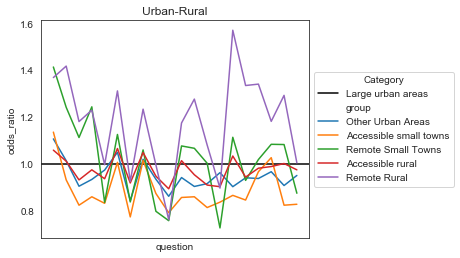

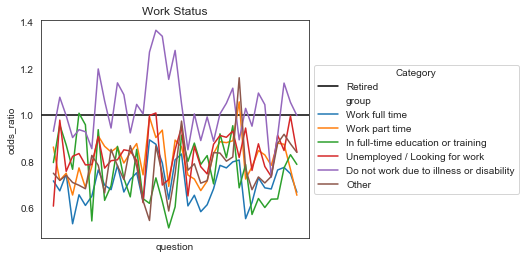

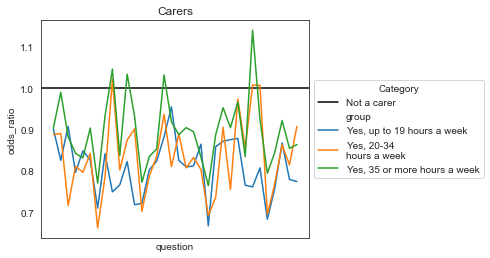

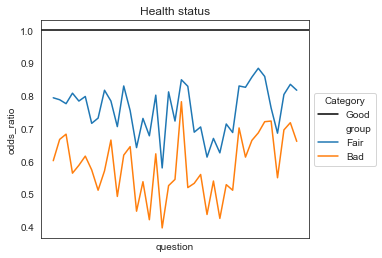

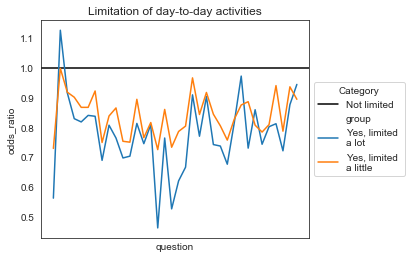

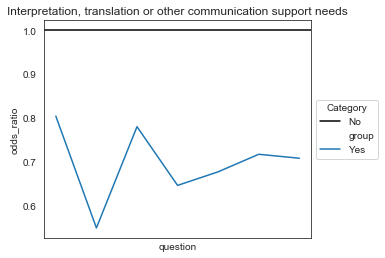

In [14]:
for charac in df['characteristic'].unique():
    plt.axhline(1, label=df[df['characteristic']==charac].base_group.iloc[0], c='black')
    sns.lineplot(df[df['characteristic']==charac].question, 
                 df[df['characteristic']==charac].odds_ratio,
                hue = df[df['characteristic']==charac].group)

    ax = plt.gca()
    ax.axes.get_xaxis().set_ticks([])
    ax.set_title(charac)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    l = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    l.set_title('Category')
    
    plt.show()

### Scatterplot
Next, let's zoom in a bit more and look at some different parts of the data. One of the characteristics considered in the model is whether patients have interpretation, translation, or other communication support needs. We already saw that they generally report worse experiences, but now we can see the specific questions and confidence intervals.

I had to manually plot lines to visualise the confidence interval into this plot, since plotting functions do not generally allow for inputting your own confidence interval. I also tested this graph for other characteristics, however it becomes difficult to see when there are multiple overlapping data points and especially overlapping confidence intervals.

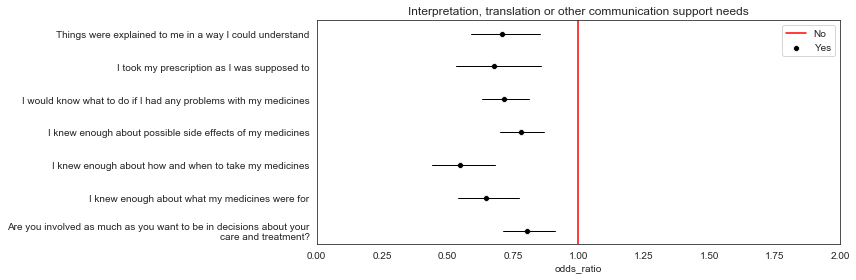

In [15]:
# Select 
charac = 'Interpretation, translation or other communication support needs'

dfp = df[df.characteristic==charac].reset_index()

fig, ax = plt.subplots(figsize=(12,4))

for i, row in dfp.iterrows():
    ax.plot([row.conf_lower, row.conf_upper],[i,i], c='black', linewidth=1)

sns.scatterplot(x = dfp.odds_ratio,
               y = [ '\n'.join(wrap(l, 70)) for l in dfp.question ],
               label = dfp.group.iloc[0],
               color='black')

plt.axvline(x=1, c='red', label=dfp.base_group.iloc[0])
plt.xlim(xmax = 2, xmin = 0)
plt.title(charac)
plt.legend()
plt.tight_layout()
plt.show()

### Heatmap
Heatmaps seem like a better way of visualising the overall experiences of patients when they are split into more groups. The downside is that there is no way to include the confidence intervals here, and it also becomes quite long with a large number of questions.

Nonetheless, the heatmap for the characteristic *Work Status* below shows nicely that almost all groups report worse experiences on most questions compared to retirees. The only exception are those who do not work due to illness or disability. Their reported experiences are largely on par with retirees, and better in some cases, especially in the theme of 'Medicines'. 

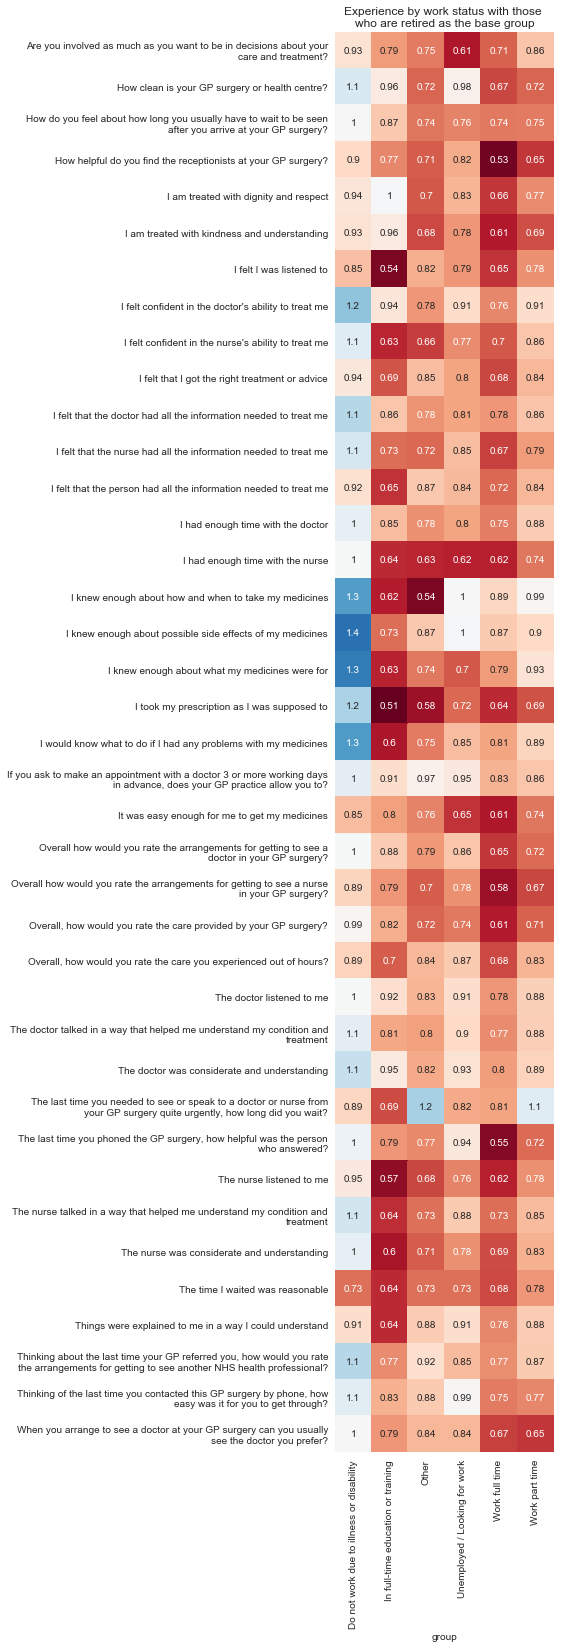

In [16]:
heatdf = df[df['characteristic']=='Work Status'].pivot_table(values='odds_ratio', index='question', columns='group')
heatdf.index = [ '\n'.join(wrap(l, 70)) for l in heatdf.index ]
fig, ax = plt.subplots(figsize=(12,23))
sns.heatmap(heatdf, center=1, annot=True, cmap='RdBu',
            square=True, cbar=False)
plt.title('Experience by work status with those \nwho are retired as the base group')
plt.tight_layout()
plt.show()

### Scatterplot Matrix

Lastly, I wanted to see if there might be any correlations between the different questions. Questions related to Medicines seemed to have similar colours for each group in the heatmap, so I am plotting all odds ratios for the questions in the theme 'Medicines'. Here we can see that there are indeed correlations: With one exception, most questions are positively correlated with the other questions. Essentially, this implies that if someone has a better/worse experience with one aspect of their medicines, it is likely that they have a better/worse experience with most/all aspects of their medicines. The exception is the statement 'It was easy enough to get my medicines', which seems to be unrelated to the other questions in the theme.

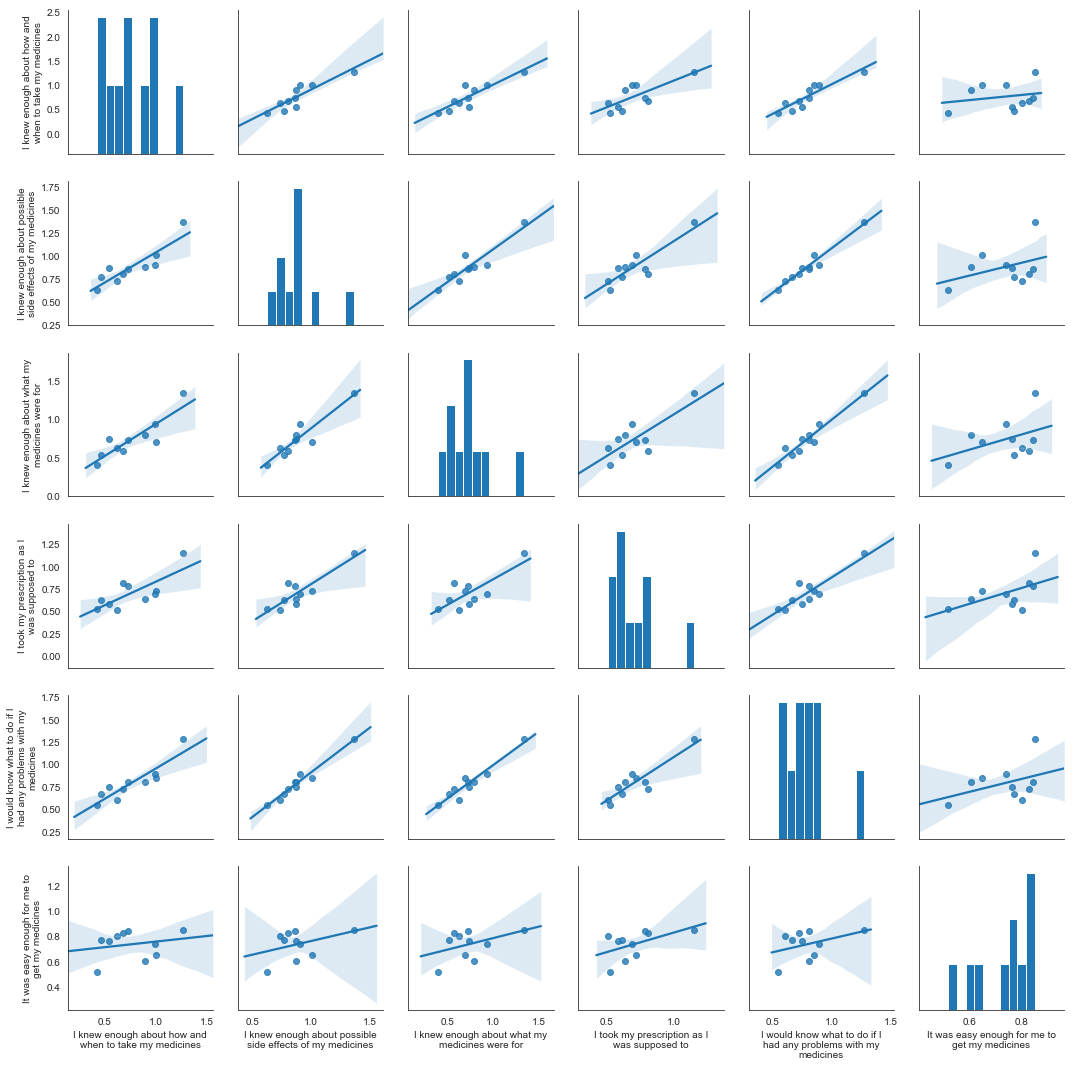

In [17]:
pairdf = df[df['theme']=='Medicines'].pivot_table(values='odds_ratio', index='group', columns='question')
pairdf.columns = [ '\n'.join(wrap(l, 30)) for l in pairdf.columns ]
sns.pairplot(pairdf.dropna(), kind='reg')
plt.show()

## Reflect and Hypothesise

### Reflection

At first sight, the data we are working with seems rather dry, and considering that it is the result of a complex statistical analysis, I would not expect anything hidden to still be present in this data. In fact, there are not a whole lot of relationships to be investigated in this dataset, because there is only one data type (the odds ratio) and its confidence interval.

However, through this analysis, I discovered that by looking at the data from as many angles as possible (by theme, by characteristic, by question, ...), interesting insights can be found. It seems that relationships between experiences reported for different questions are present. In addition, our data is highly relevant for almost anyone who lives in Scotland - after all, healthcare concerns everyone. The goal of the second part of our project is to create visualisations that make this dataset more accessible, mainly targeted at policy makers. This means our project can make a real difference in the lives of many people, if it results in policies being based around insights from this data.

As for my personal learning from this assignment, it really forced me to learn how to use plotting tools in Python. I tend to very quickly move to D3 when I can't seem to get a plot to work they way I want it to in R or Python. All of my plots in this notebook started out with a lot more lines of code than there are now, and I simplified them a lot over the course of working on this assignment. It might seem like a simple insight, but formatting the data in exactly the way the plotting function wants it is much easier than trying to get the plotting function to accept it in a different format.


### Hypotheses
- The experiences people reported for the different questions/statements in a theme, or even in general, are correlated.
    - Why I think this: Especially the scatterplot matrix suggests this, but the heatmap also shows some evidence of clusters of similar colours.
    - How would I test it: I could begin by further exploring this using more scatterplot matrices. A linear regression analysis could confirm whether or not there are significant relationships. However, I am unsure whether applying this to odds ratios would be acceptable, and would need to confirm this with someone with more in-depth statistics knowledge (e.g. our data holders).
- Minorities more often report worse experiences.
    - Why I think this: In all of the plots it is obvious that the majority of the odds ratios are below 1. Considering that the largest group was typically chosen as the base group, it seems that the smaller groups report worse experiences overall.
    - How would I test it: The difficulty would be to firstly define the term minority. It could either be taken to mean the smaller group(s), or it could mean any non-dominant social group. For many characteristics in this dataset, this would be the same, but e.g. for Gender it would make a big difference. Depending on the definition, additional data such as the size of different demographic groups in the Scottish population might be required to investigate this hypothesis. A regression analysis would probably be the best tool for this.
- The more restricted someone's schedule, the worse their experience.
    - Why I think this: It seems that people in full-time work as well as carers report worse experiences than their respective base groups. One possible explanation is that they are only able to see their doctor during certain times in the day, which might impact their care simply due to those times being busy.
    - How would I test it: I would need to classify all the different groups into whether or not (or how much) belonging to that group impacts how freely people can schedule their day, and then compare whether this group reports a worse experience overall than the group who is more free.
    
The following is not really a hypothesis, but more of an avenue I thought might be interesting to investigate with additional data:
- Is there a relationship between the absolute average experience and the variation? I.e. might the variation be generally lower or higher for question where in general a better or worse experience is reported?
    - Why I think this: There is quite a bit of variation in how much variation there is per question, and there might be underlying reasons for that.
    - How would I test it: To investigate this, I would need to get the absolute scores on each question from a different dataset, then find a measure for the variation on each question, and then check if there is a significant correlation between the two.
